In [ ]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced visualizations

# Ignore warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

# Machine learning and preprocessing libraries
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import TensorFlow for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential  # For building the CNN model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D  # CNN-specific layers
from tensorflow.keras.optimizers import Adam  # Optimizer for the model


# Mount Google Drive to access the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the dataset
dataset_path = "/content/drive/MyDrive/ScholarshipAwardDecisionTool/"
scholarship_df = pd.read_excel(dataset_path + "dataset_combined.xlsx", engine='openpyxl')


Mounted at /content/drive


In [ ]:
# Display the first 3 rows of the dataset
print(scholarship_df.head(3))

                                                Name Education Qualification  \
0  INSPIRE Scholarship 2022-23 ? Scholarship for ...           Undergraduate   
1  INSPIRE Scholarship 2022-23 ? Scholarship for ...           Undergraduate   
2  INSPIRE Scholarship 2022-23 ? Scholarship for ...           Undergraduate   

  Gender Community Religion Exservice-men Disability Sports Annual-Percentage  \
0   Male   General    Hindu           Yes        Yes    Yes            90-100   
1   Male   General    Hindu           Yes        Yes     No            90-100   
2   Male   General   Muslim           Yes        Yes    Yes            90-100   

      Income India  Outcome  
0  Upto 1.5L    In        1  
1  Upto 1.5L    In        1  
2  Upto 1.5L    In        1  


In [ ]:

scholarship_df.columns


Index(['Community', 'Annual-Percentage', 'India', 'Outcome',
       'Education_Qualification', 'Income_Level', 'Gender_Female',
       'Gender_Male', 'Disability_No', 'Disability_Yes', 'Sports_No',
       'Sports_Yes'],
      dtype='object')

# Exploratory Data Analysis (EDA)

In [ ]:
# 1. **Check for missing values**
missing_values = scholarship_df.isnull().sum()  # Count missing values in each column
print("Missing Values:\n", missing_values)

Missing Values:
 Community                  0
Annual-Percentage          0
India                      0
Outcome                    0
Education_Qualification    0
Income_Level               0
Gender_Female              0
Gender_Male                0
Disability_No              0
Disability_Yes             0
Sports_No                  0
Sports_Yes                 0
dtype: int64


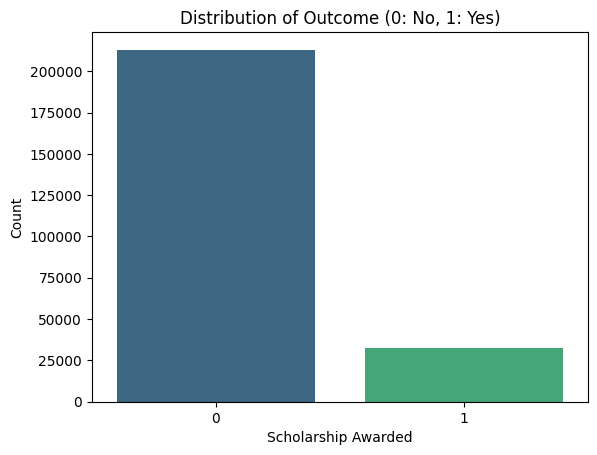

In [ ]:
# 2. **Distribution of target variable (Outcome)**
sns.countplot(data=scholarship_df, x="Outcome", palette="viridis")
plt.title("Distribution of Outcome (0: No, 1: Yes)")
plt.xlabel("Scholarship Awarded")
plt.ylabel("Count")
plt.show()

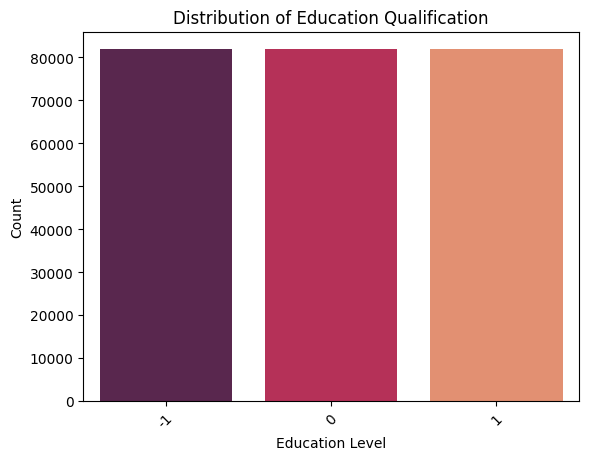

In [ ]:
# 4. **Education Qualification distribution**
sns.countplot(data=scholarship_df, x="Education_Qualification", palette="rocket")
plt.title("Distribution of Education Qualification")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

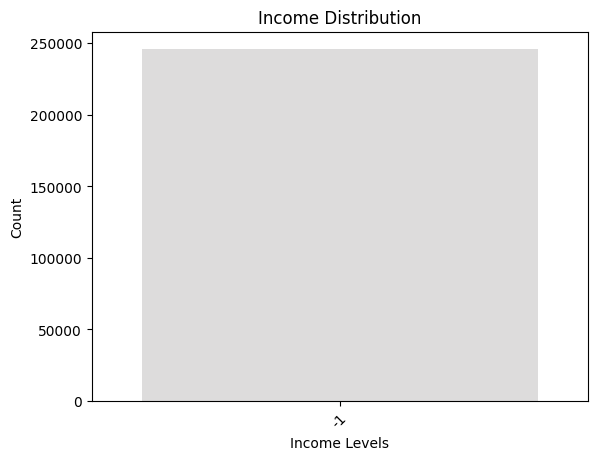

In [ ]:
# 6. **Income distribution specific to Kenya**
sns.countplot(data=scholarship_df, x="Income_Level", palette="coolwarm")
plt.title("Income Distribution")
plt.xlabel("Income Levels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

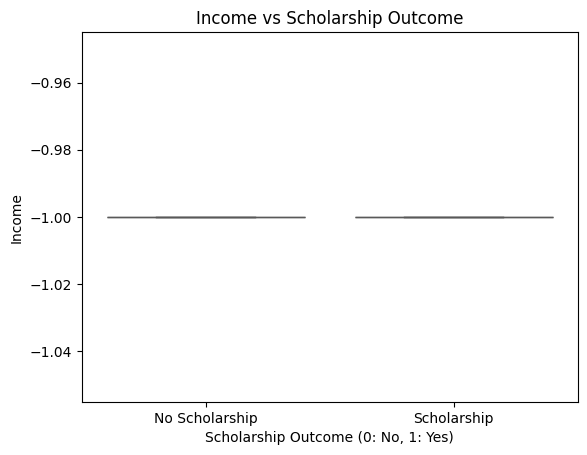

In [ ]:
# 7. **Boxplot of Income vs Outcome**
sns.boxplot(data=scholarship_df, x="Outcome", y="Income_Level", palette="Set2")
plt.title("Income vs Scholarship Outcome")
plt.xlabel("Scholarship Outcome (0: No, 1: Yes)")
plt.ylabel("Income")
plt.xticks([0, 1], ["No Scholarship", "Scholarship"])
plt.show()

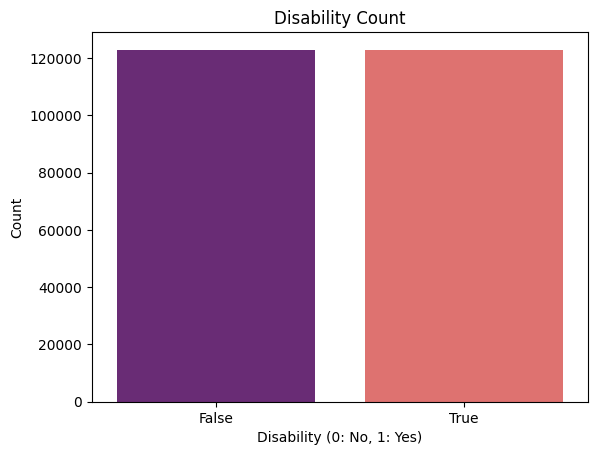

In [ ]:
sns.countplot(data=scholarship_df, x="Disability_Yes", palette="magma")
plt.title("Disability Count")
plt.xlabel("Disability (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

# Data Preprocessing

In [ ]:
# Drop irrelevant columns that are not useful for prediction in Kenya
scholarship_df = scholarship_df.drop(["Name", "Religion", "Exservice-men"], axis=1)

In [ ]:
# Function to encode ordinal features with a specific order
def ordinal_encoding(dataframe, col_name, categories, new_col_name):
    enc = OrdinalEncoder(categories=[categories])  # Define the encoder with specific categories
    categories = pd.Categorical(dataframe[col_name], categories=categories, ordered=True)  # Ensure correct order
    labels, unique = pd.factorize(categories, sort=True)  # Convert to numerical values
    dataframe[new_col_name] = labels  # Add the encoded column to the dataframe
    return dataframe


In [ ]:
# Encode Education Qualification
categories = ["Undergraduate", "Diploma", "Postgraduate"]
scholarship_df = ordinal_encoding(scholarship_df, "Education Qualification", categories, "Education_Qualification")


In [ ]:
# Encode Income levels tailored to Kenya
categories = ["Below 200K", "200K-500K", "500K-1M", "Above 1M"]
scholarship_df = ordinal_encoding(scholarship_df, "Income", categories, "Income_Level")


In [ ]:
# One-hot encoding for categorical features like Gender, Disability, and Sports
scholarship_df = pd.get_dummies(scholarship_df, columns=["Gender", "Disability", "Sports"])


In [ ]:
# Drop original columns after encoding
scholarship_df = scholarship_df.drop(["Education Qualification", "Income"], axis=1)


In [ ]:
# Separate target variable (y) and features (X)
y = scholarship_df["Outcome"]  # Target variable
X = scholarship_df.drop("Outcome", axis=1)  # Features


In [ ]:
# Select only numerical features for scaling
numerical_features = X.select_dtypes(include=np.number).columns
X_scaled = scaler.fit_transform(X[numerical_features])  # Scale the numerical features only

# Create a new DataFrame with scaled numerical features
X_scaled = pd.DataFrame(X_scaled, columns=numerical_features, index=X.index)

# Concatenate scaled numerical features with non-numerical features
X = pd.concat([X.drop(columns=numerical_features), X_scaled], axis=1)

In [ ]:
# Reshape the data for CNN input (samples, time steps, features)
X_scaled = X_scaled.values.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)


# Data Splitting

In [ ]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# CNN Model Definition

In [ ]:
# Initialize a Sequential CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),  # 1D convolutional layer
    MaxPooling1D(pool_size=1),  # Max pooling to reduce dimensionality
    Dropout(0.5),  # Dropout for regularization
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),  # Second convolutional layer, added padding='same'
    # MaxPooling1D(pool_size=2),  # Remove or adjust this MaxPooling1D layer - It's causing the error
    # If you need to reduce dimensionality, consider using a smaller pool_size (e.g., pool_size=1)
    # or adjusting the kernel_size and strides in the Conv1D layers.
    Dropout(0.5),  # Dropout for regularization
    Flatten(),  # Flatten the 3D output to 1D for Dense layers
    Dense(64, activation='relu'),  # Fully connected dense layer
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [ ]:
# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Model Training

In [ ]:
# Train the model using the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8661 - loss: 0.4036 - val_accuracy: 0.8665 - val_loss: 0.3833
Epoch 2/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8670 - loss: 0.3869 - val_accuracy: 0.8665 - val_loss: 0.3836
Epoch 3/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8667 - loss: 0.3854 - val_accuracy: 0.8665 - val_loss: 0.3834
Epoch 4/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8664 - loss: 0.3856 - val_accuracy: 0.8665 - val_loss: 0.3831
Epoch 5/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8683 - loss: 0.3818 - val_accuracy: 0.8665 - val_loss: 0.3837
Epoch 6/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8665 - loss: 0.3845 - val_accuracy: 0.8665 - val_loss: 0.3832
Epoch 7/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8671 - loss: 0.3834 - val_accuracy: 0.8665 - val_loss: 0.3831
Epoch 8/50
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8672 - loss: 0

# Model Evaluation

In [ ]:
# Evaluate the model on the test data
results = model.evaluate(X_test, y_test, verbose=0)  # Get test loss and accuracy
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Test Loss: 0.3815801441669464, Test Accuracy: 0.8669026494026184


In [ ]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).flatten()  # Round predictions to nearest integer for binary classification


1536/1536 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


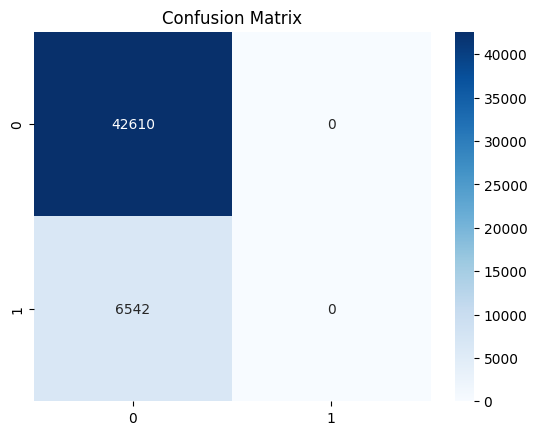

In [ ]:
# Confusion Matrix to evaluate predictions
cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')  # Visualize confusion matrix
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report for detailed metrics
print(classification_report(y_test, y_pred))  # Print precision, recall, F1-score, etc.


              precision    recall  f1-score   support

           0       0.87      1.00      0.93     42610
           1       0.00      0.00      0.00      6542

    accuracy                           0.87     49152
   macro avg       0.43      0.50      0.46     49152
weighted avg       0.75      0.87      0.81     49152



# Training Metrics Visualization

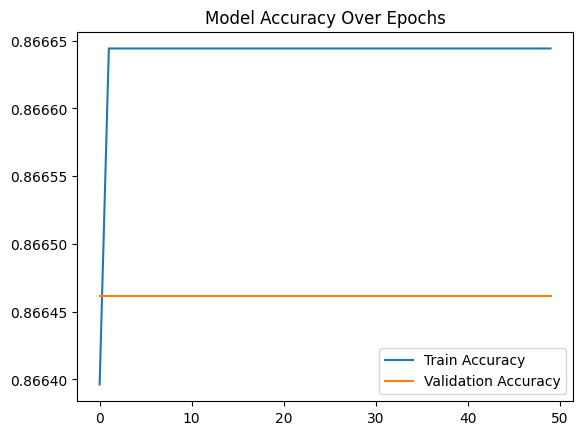

In [ ]:
# Plot model accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.legend()  # Add legend to distinguish lines
plt.title('Model Accuracy Over Epochs')  # Title of the plot
plt.show()


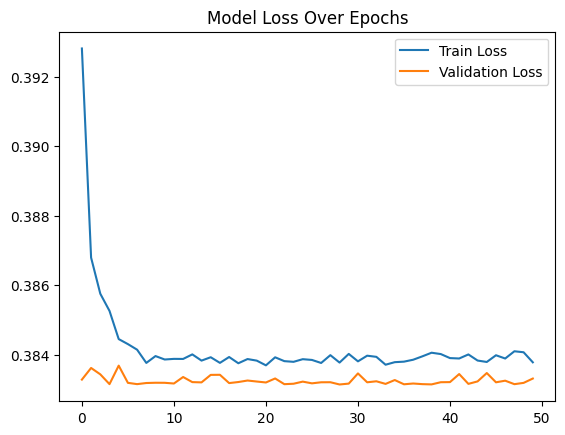

In [ ]:
# Plot model loss over epochs
plt.plot(history.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.legend()  # Add legend to distinguish lines
plt.title('Model Loss Over Epochs')  # Title of the plot
plt.show()

# Save the Model

In [ ]:
# Save the trained CNN model for future use
model.save("kenya_scholarship_cnn_model.h5")  # Save the model in HDF5 format